# 1. 임포트

In [36]:
# 1. 데이터 임포트
import pandas as pd

# 2. 변수 처리
from sklearn.preprocessing import OneHotEncoder


# 3. 모델 함수 제작
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler



# 한글 폰트 깨짐 방지
from matplotlib import font_manager, rc
font_path = "C:/Users/Jung_a/AppData/Local/Microsoft/Windows/Fonts/NanumGothic.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [2]:
df = pd.read_csv("data/data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     92 non-null     int64  
 1   title          92 non-null     object 
 2   week           92 non-null     object 
 3   rank           92 non-null     int64  
 4   star_mean      92 non-null     float64
 5   large_genre    92 non-null     object 
 6   small_genre    92 non-null     object 
 7   heart          92 non-null     int64  
 8   isnovel        92 non-null     int64  
 9   america_title  92 non-null     object 
 10  america_rank   92 non-null     int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 8.0+ KB


In [4]:
df.drop(["Unnamed: 0"],inplace=True,axis=1)

# 2. 변수 처리

## 2.1 카테고리 변수 숫자형으로 변형

In [5]:
df["small_genre"].unique()

array(['액션', '판타지', '드라마', '로맨스', '스릴러', '감성', '스포츠', '무협/사극'],
      dtype=object)

In [6]:
## 2.1 수가 적으므로 감성, 스포츠, 스릴러는 제거 & 무협/사극은 액션으로 통일

### 감성, 스릴러, 스포츠인 행 찾기
df[(df["small_genre"] == "감성") | (df["small_genre"] == "스포츠") | (df["small_genre"] == "스릴러")]

,title,week,rank,star_mean,large_genre,small_genre,heart,isnovel,america_title,america_rank
4,꼬리잡기,mon,21,9.94,스토리,스릴러,1491,0,Chasing Tails,40
11,슈퍼스타 천대리,mon,75,9.81,스토리,감성,132,1,Superstar Associate Manager,54
29,여고생 드래곤,wed,8,9.97,스토리,스포츠,99999,0,Teenage Dragon,42
66,네버엔딩달링,fri,74,9.95,스토리,스릴러,746,0,Never-Ending Darling,33


In [7]:
### 감성, 스릴러, 스포츠인 행 제거

df.drop([4,11,29,66], axis=0,inplace=True)
df.reset_index(drop=True,inplace=True)

In [8]:
df[df["small_genre"] == "무협/사극"]

### 직접 작품을 찾아본 결과, 액션으로 분류해도 무리가 없음

,title,week,rank,star_mean,large_genre,small_genre,heart,isnovel,america_title,america_rank
31,칼에 취한 밤,wed,20,9.89,스토리,무협/사극,295,1,A Dance of Swords in the Night,34
37,나노마신,thu,3,9.92,스토리,무협/사극,57943,1,Nano Machine,51
53,광마회귀,fri,8,9.97,스토리,무협/사극,2498,1,Return of the Mad Demon,10
86,일타강사 백사부,sun,48,9.95,스토리,무협/사극,719,1,Best Teacher Baek,24


In [9]:
### 무협/사극 -> 액션 장르로 변환
df.loc[df["small_genre"]=="무협/사극","small_genre"] = "액션"

## 2.2 인코딩


In [10]:
onehotencoder = OneHotEncoder()

X = onehotencoder.fit_transform(df.small_genre.values.reshape(-1,1)).toarray()

# 드라마: 1000, 로맨스: 0100, 액션: 0010, 판타지: 0001
df_one_hot = pd.DataFrame(X,columns =["드라마","로맨스","액션","판타지"])

df = pd.concat([df,df_one_hot],axis=1)
df = df.drop(["small_genre"],axis=1)

In [11]:
df.head()

,title,week,rank,star_mean,large_genre,heart,isnovel,america_title,america_rank,드라마,로맨스,액션,판타지
0,참교육,mon,1,9.86,스토리,20645,0,Get Schooled,8,0.0,0.0,1.0,0.0
1,신화급 귀속,mon,7,9.88,스토리,477,1,Mythic Item Obtained,13,0.0,0.0,0.0,1.0
2,소녀의 세계,mon,13,9.93,스토리,99999,0,Odd Girl Out,11,1.0,0.0,0.0,0.0
3,북부 공작님을,mon,20,9.96,스토리,535,1,Charming the Duke of the North,22,0.0,1.0,0.0,0.0
4,물어보는 사이,mon,22,9.96,스토리,1766,0,Bitten Contract,14,0.0,1.0,0.0,0.0


# 2.3 america_rank 범주형으로 변형

In [12]:
# 분류 모델 사용 위해 america_rank를 범주형으로 변형
# america_rank가 상위 20위 이하면 1, 20위 밖이면 0

print(len(df[df["america_rank"] <= 20]))
print(len(df[df["america_rank"] > 20]))

46
42


In [13]:
df.loc[df["america_rank"] <= 20,"success"] = 1
df.loc[df["america_rank"] > 20,"success"] = 0

In [14]:
df.head()

,title,week,rank,star_mean,large_genre,heart,isnovel,america_title,america_rank,드라마,로맨스,액션,판타지,success
0,참교육,mon,1,9.86,스토리,20645,0,Get Schooled,8,0.0,0.0,1.0,0.0,1.0
1,신화급 귀속,mon,7,9.88,스토리,477,1,Mythic Item Obtained,13,0.0,0.0,0.0,1.0,1.0
2,소녀의 세계,mon,13,9.93,스토리,99999,0,Odd Girl Out,11,1.0,0.0,0.0,0.0,1.0
3,북부 공작님을,mon,20,9.96,스토리,535,1,Charming the Duke of the North,22,0.0,1.0,0.0,0.0,0.0
4,물어보는 사이,mon,22,9.96,스토리,1766,0,Bitten Contract,14,0.0,1.0,0.0,0.0,1.0


## 2.4 모델에 사용할 data, target 생성

In [134]:
### 요일, large_genre, america_title, america_rank, title 제거

pre_df = df.drop(["rank","week","large_genre","america_title","america_rank"],axis=1)

In [135]:
pre_df.head()

,title,star_mean,heart,isnovel,드라마,로맨스,액션,판타지,success
0,참교육,9.86,20645,0,0.0,0.0,1.0,0.0,1.0
1,신화급 귀속,9.88,477,1,0.0,0.0,0.0,1.0,1.0
2,소녀의 세계,9.93,99999,0,1.0,0.0,0.0,0.0,1.0
3,북부 공작님을,9.96,535,1,0.0,1.0,0.0,0.0,0.0
4,물어보는 사이,9.96,1766,0,0.0,1.0,0.0,0.0,1.0


In [136]:
### 모델에 사용할 데이터 생성
df_data = pre_df.iloc[:,1:8]
df_target = pre_df.iloc[:,8]

In [154]:
### 모델에 사용할 데이터 저장

df_data.to_excel('df_data.xlsx')
df_data.to_csv('df_data.csv')

In [155]:
df_target.to_excel('df_target.xlsx')
df_target.to_csv('df_target.csv')

# 3. 모델 함수 제작

In [138]:
## 3.1 데이터 스플릿
### stratify 설정시 오류 발생 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_data, df_target, test_size=0.4, random_state=23) 

In [139]:
## 3.2 표준화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [140]:
## 3.3 모델 제작 함수 제작
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

kfold =  StratifiedKFold(n_splits=3) 

def make_model(model_name,model, hyperparam_grid):
    print(f"================{model_name}모델================")

    grid_model = GridSearchCV(model, hyperparam_grid, scoring="accuracy", cv=kfold)
    grid_model.fit(X_train_scaled, y_train)
    y_test_hat = grid_model.predict(X_test_scaled)  

    print(f"모델의 best_score:",grid_model.best_score_)
    print(f"모델의 best_params:",grid_model.best_params_)
    print(f"모델의 accuracy score: ",accuracy_score(y_test, y_test_hat))
    print(f"모델의 roc_auc_score: ",roc_auc_score(y_test,  y_test_hat))
    
    print(f"모델의 일반화 평가")
    print(classification_report(y_test,y_test_hat))

    print(f"모델의 confusion_matrix ")
    print(confusion_matrix(y_test,  y_test_hat))

    return grid_model.best_estimator_

In [141]:
## 3.3 모델의 feature importance를 보여주는 함수
import seaborn as sns

def show_importance(model_name,model):
    print(f"===={model_name}의 feature importance====")
    feature_importance = sorted([(name,value) for name,value in zip(df_data.columns, model.feature_importances_)],key=lambda x : x[1],reverse=True) # importance 값으로 내림차순 정렬
    for i in feature_importance:
        print('{0} : {1:.3f}'.format(i[0], i[1]))
    sns.barplot(x=model.feature_importances_, y=df_data.columns)

In [142]:
## 3.4 성공 여부 확인 함수
def isSuccess(cartoon_value,model):
    isSuccessd = 'not success' if model.predict([cartoon_value])[0] == 0 else 'success!'
    print(f'I am {isSuccessd} --> 확률: {max(model.predict_proba([cartoon_value])[0])*100:.3f}%')

# 4. 미국 성공 예측 모델 만들기

## 4.1  decision tree

In [143]:
from sklearn.tree import DecisionTreeClassifier
hyperparam_grid =  {'max_depth':[1,2,3,4,5,6, 8,], 
                    'min_samples_split':[2,3,4,5,8,],
                    'min_samples_leaf': [1, 8, 6, 12],
                    'criterion':['entropy','gini']
                   }
best_dt_model = make_model("DT",DecisionTreeClassifier(random_state=23),hyperparam_grid)

================DT모델================
모델의 best_score: 0.6732026143790849
모델의 best_params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4}
모델의 accuracy score:  0.4722222222222222
모델의 roc_auc_score:  0.4907120743034056
모델의 일반화 평가
              precision    recall  f1-score   support

         0.0       0.50      0.16      0.24        19
         1.0       0.47      0.82      0.60        17

    accuracy                           0.47        36
   macro avg       0.48      0.49      0.42        36
weighted avg       0.48      0.47      0.41        36

모델의 confusion_matrix 
[[ 3 16]
 [ 3 14]]


====DT의 feature importance====
heart : 0.587
star_mean : 0.233
isnovel : 0.144
로맨스 : 0.036
드라마 : 0.000
액션 : 0.000
판타지 : 0.000


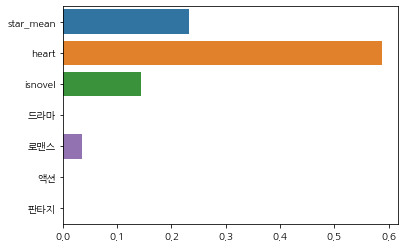

In [144]:
### 4.1.2 decision tree 모델의 feature importance
show_importance("DT",best_dt_model)

In [145]:
### 4.1.3 decision tree 모델에서의 성공 여부
# 리스트 순서: star_mean heart isnovel 드라마 로맨스 액션 판타지 sex
cartoon1 = [9.96, 530, 0, 1, 0, 0, 0] #자매전쟁  미국 18위
cartoon2 = [2, 1, 1, 1, 0, 0, 1]

isSuccess(cartoon1,best_dt_model)
isSuccess(cartoon2,best_dt_model)

I am success! --> 확률: 66.667%
I am success! --> 확률: 66.667%


## 4.2 random forest

In [146]:
### random forest
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=50, random_state=20, n_jobs=1)
hyperparam_grid =  {
    'max_depth' : [1, 2, 3, 4, 5], 
    'min_samples_split' : [2, 3, 4, 5],
    "min_samples_leaf": [1, 2, 3, 4, 5,],
    'criterion' : ['entropy','gini'],
    'max_features' : ["sqrt", "log2", None],
    
}
best_rf_model = make_model("RF",RF,hyperparam_grid)

================RF모델================
모델의 best_score: 0.5980392156862745
모델의 best_params: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}
모델의 accuracy score:  0.4722222222222222
모델의 roc_auc_score:  0.5
모델의 일반화 평가
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        19
         1.0       0.47      1.00      0.64        17

    accuracy                           0.47        36
   macro avg       0.24      0.50      0.32        36
weighted avg       0.22      0.47      0.30        36

모델의 confusion_matrix 
[[ 0 19]
 [ 0 17]]


C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


====RF의 feature importance====
star_mean : 0.433
heart : 0.341
isnovel : 0.112
판타지 : 0.053
드라마 : 0.041
로맨스 : 0.018
액션 : 0.003


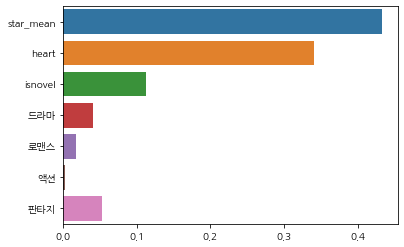

In [147]:
### 4.2.2 random forest 모델의 feature importance
show_importance("RF",best_rf_model)

In [153]:
### 4.2.3 random forest 모델에서의 성공 여부
# 리스트 순서: star_mean heart isnovel 드라마 로맨스 액션 판타지
cartoon1 = [9.96, 530, 0, 1, 0, 0, 0] #자매전쟁  미국 18위
cartoon2 = [2, 1, 1, 0, 0, 0, 1]

isSuccess(cartoon1,best_rf_model)
isSuccess(cartoon2,best_rf_model)

I am success! --> 확률: 66.131%
I am success! --> 확률: 69.044%


## 4.3  logistic regression

In [149]:
### 4.3.1 logistic regression 모델 만들고 평가하기

from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state=20, n_jobs=1)

hyperparam_grid =  {
    "C" : [0.01, 0.1, 1],
    "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

best_lr_model = make_model("LR", LR, hyperparam_grid)

================LR모델================
모델의 best_score: 0.5577342047930284
모델의 best_params: {'C': 0.01, 'solver': 'newton-cg'}
모델의 accuracy score:  0.4722222222222222
모델의 roc_auc_score:  0.5
모델의 일반화 평가
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        19
         1.0       0.47      1.00      0.64        17

    accuracy                           0.47        36
   macro avg       0.24      0.50      0.32        36
weighted avg       0.22      0.47      0.30        36

모델의 confusion_matrix 
[[ 0 19]
 [ 0 17]]


C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


====LR의 coef====
star_mean : 0.04046373835192551 
isnovel : 0.03553533854070491 
드라마 : -0.012203167310501997 
로맨스 : 0.007468507294747428 
액션 : -0.0069440139341429875 
heart : 0.00666170583697445 
판타지 : 0.005414901985017968 


<AxesSubplot:>

C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


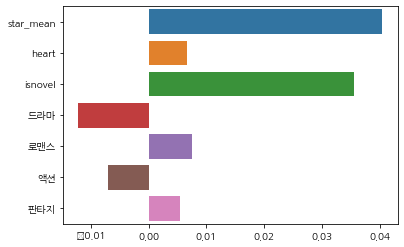

In [150]:
### 4.3.2 logistic regression의 coef

print("====LR의 coef====")
feature_importance = sorted([(name,value) for name,value in zip(df_data.columns, best_lr_model.coef_[0])],key=lambda x : abs(x[1]),reverse=True) # coef 절대값으로 내림차순 정렬
for i in feature_importance:
    print(f"{i[0]} : {i[1]} ")
sns.barplot(x=best_lr_model.coef_[0], y=df_data.columns)

In [152]:
### 4.3.3 logistic regression의 모델에서의 성공 여부
# 리스트 순서: star_mean heart isnovel 드라마 로맨스 액션 판타지
cartoon1 = [9.96, 530, 0, 1, 0, 0, 0] #자매전쟁  미국 18위
cartoon2 = [2, 1, 1, 0, 0, 0, 1]

isSuccess(cartoon1,best_lr_model)
isSuccess(cartoon2,best_lr_model)

I am success! --> 확률: 98.453%
I am success! --> 확률: 58.915%
